<a href="https://colab.research.google.com/github/isa-estes/rice-datathon23/blob/main/rice_datathon23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import numpy as np
import pandas as pd
from plotnine import *

In [135]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import * 

In [136]:
url = 'https://raw.githubusercontent.com/isa-estes/rice-datathon23/main/Investment_Data_Train.xlsx%20-%20train_data.csv'
df = pd.read_csv(url)

In [137]:
# modifies the input dataframe to be further analyzed
def pre_clean(copy):
  df = copy.copy(deep=True)
  # drop unnecessary column 
  df.drop(['Unnamed: 0'], axis=1, inplace=True)
  # year is categorical 
  df['Year'] = df.Year.astype(str)
  # don't care about the US, just noisy data
  df = df[df['StateCode'] != 'US']
  # widen the dataframe
  df = df.pivot(index=['State', 'Year', 'StateCode', 'CO2 Emissions (Mmt)',
       'TotalNumberofInvestments', 'TotalAmountofAssistance'], columns=['MSN'], 
       values='Amount')
  df.reset_index(inplace=True)
  return df


In [138]:
feat_df = pre_clean(df)

# **Looking at + Cleaning the Data**

In [139]:
# look at the top of the dataset
feat_df.head(10)

MSN,State,Year,StateCode,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance,BDFDB,BDPRP,BFFDB,BFPRP,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
0,Alabama,2015,AL,119.200889,164.0,1864412.0,1933.0,356.0,1933.0,356.0,...,258955.0,101.0,1267004.0,1917138.0,0.0,163313.0,163313.0,1565.0,164877.0,0.0
1,Alabama,2016,AL,113.983783,129.0,1206793.0,1906.0,351.0,1906.0,351.0,...,230734.0,431.0,1118407.0,1922727.0,0.0,162166.0,162166.0,1606.0,163772.0,0.0
2,Alabama,2017,AL,108.594378,104.0,2414699.0,1585.0,292.0,1585.0,292.0,...,258549.0,1812.0,1230179.0,1904206.0,1137.0,168195.0,167058.0,1712.0,169907.0,0.0
3,Alabama,2018,AL,112.355471,75.0,1844186.0,1652.0,304.0,1652.0,304.0,...,279560.0,3425.0,1245875.0,1956413.0,4462.0,171215.0,166753.0,1680.0,172895.0,0.0
4,Alabama,2019,AL,106.250752,54.0,840218.0,1494.0,275.0,1494.0,275.0,...,278142.0,3628.0,1250624.0,1926332.0,5308.0,169739.0,164431.0,1577.0,171316.0,0.0
5,Alaska,2015,AK,35.027804,16.0,3345612.0,21.0,4.0,21.0,4.0,...,23807.0,3.0,1429942.0,614242.0,0.0,6865.0,6865.0,622.0,7488.0,1488.0
6,Alaska,2016,AK,33.405611,14.0,2247734.0,27.0,5.0,27.0,5.0,...,25155.0,14.0,1435363.0,593662.0,0.0,7636.0,7636.0,412.0,8048.0,1563.0
7,Alaska,2017,AK,33.729130,18.0,13509662.0,29.0,5.0,29.0,5.0,...,23620.0,20.0,1454196.0,601492.0,0.0,6501.0,6501.0,436.0,6937.0,1305.0
8,Alaska,2018,AK,34.514589,44.0,18236626.0,15.0,3.0,15.0,3.0,...,24158.0,28.0,1410604.0,604644.0,0.0,6910.0,6910.0,456.0,7366.0,1411.0
9,Alaska,2019,AK,34.259440,32.0,13734021.0,0.0,0.0,0.0,0.0,...,22754.0,40.0,1370342.0,605689.0,0.0,6418.0,6418.0,386.0,6803.0,1270.0


In [140]:
# look at the bottom of the dataset
feat_df.tail(10)

MSN,State,Year,StateCode,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance,BDFDB,BDPRP,BFFDB,BFPRP,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
255,Wisconsin,2015,WI,99.857015,107.0,3755629.0,2614.0,481.0,79450.0,13941.0,...,223881.0,505.0,328547.0,1814408.0,0.0,97353.0,97353.0,9334.0,106687.0,14811.0
256,Wisconsin,2016,WI,95.615319,80.0,7777098.0,3245.0,597.0,82079.0,14424.0,...,224249.0,583.0,330423.0,1801012.0,0.0,91748.0,91748.0,9430.0,101178.0,13989.0
257,Wisconsin,2017,WI,98.643088,95.0,2622475.0,1894.0,349.0,83624.0,14682.0,...,224172.0,953.0,325091.0,1817947.0,0.0,90051.0,90051.0,9333.0,99384.0,15116.0
258,Wisconsin,2018,WI,101.172770,75.0,2067441.0,2953.0,544.0,89233.0,15657.0,...,232096.0,1287.0,337996.0,1896601.0,0.0,95231.0,95231.0,9044.0,104275.0,14909.0
259,Wisconsin,2019,WI,94.822424,103.0,2915140.0,3491.0,643.0,88934.0,15643.0,...,232452.0,1483.0,337188.0,1847846.0,0.0,92350.0,92350.0,8831.0,101181.0,16722.0
260,Wyoming,2015,WY,64.092863,18.0,249960.0,0.0,0.0,1192.0,209.0,...,49887.0,27.0,9080777.0,507121.0,0.0,4904.0,4904.0,2.0,4905.0,35009.0
261,Wyoming,2016,WY,61.259993,23.0,1359346.0,0.0,0.0,0.0,0.0,...,54565.0,33.0,7518440.0,504984.0,0.0,4357.0,4357.0,2.0,4358.0,40522.0
262,Wyoming,2017,WY,62.796487,47.0,413987.0,0.0,0.0,0.0,0.0,...,55916.0,45.0,7794586.0,534840.0,0.0,5049.0,5049.0,0.0,5049.0,39806.0
263,Wyoming,2018,WY,63.846081,53.0,573639.0,0.0,0.0,0.0,0.0,...,51483.0,67.0,7711992.0,557604.0,0.0,4934.0,4934.0,0.0,4934.0,36936.0
264,Wyoming,2019,WY,59.096649,32.0,570570.0,0.0,0.0,0.0,0.0,...,53228.0,1688.0,7148285.0,546671.0,0.0,4969.0,4969.0,0.0,4969.0,37070.0


In [141]:
# look at the where missing values are in the data set
feat_df.isna().sum()

MSN
State                        0
Year                         0
StateCode                    0
CO2 Emissions (Mmt)         10
TotalNumberofInvestments    15
TotalAmountofAssistance     15
BDFDB                       10
BDPRP                       10
BFFDB                       10
BFPRP                       10
CLPRB                       10
CLPRK                       10
CLPRP                       10
COPRK                        0
EMFDB                       10
ENPRP                       10
GETCB                       10
HYTCB                       10
NCPRB                       10
NGMPB                        5
NGMPK                        5
NGMPP                        5
NUETB                       10
PAPRB                        0
PAPRP                        0
REPRB                       10
SOTCB                       10
TEPRB                        0
TETCB                       10
WDEXB                       10
WDPRB                       10
WDTCB                       10
WSTC

Let's fill in missing values in the total number of investments and total amount of assistance to be 0, since there is no data for those states. 

However, KNN Imputation is used on CO2 emission in preprocessing later on for the model since it is likely that the states did have emissions even if not reported.  

In [142]:
# make dataframes for creating plots
def plot_clean(copy): 
  df = copy.copy(deep=True)
  df.fillna(0, inplace=True)
  return df

In [143]:
plot_df = plot_clean(feat_df)

In [144]:
# plot for seeing total amount of assistance from each state 
df_assistance_plot = plot_df[['StateCode', 'Year', 'TotalAmountofAssistance']]

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 20 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: assistance.png


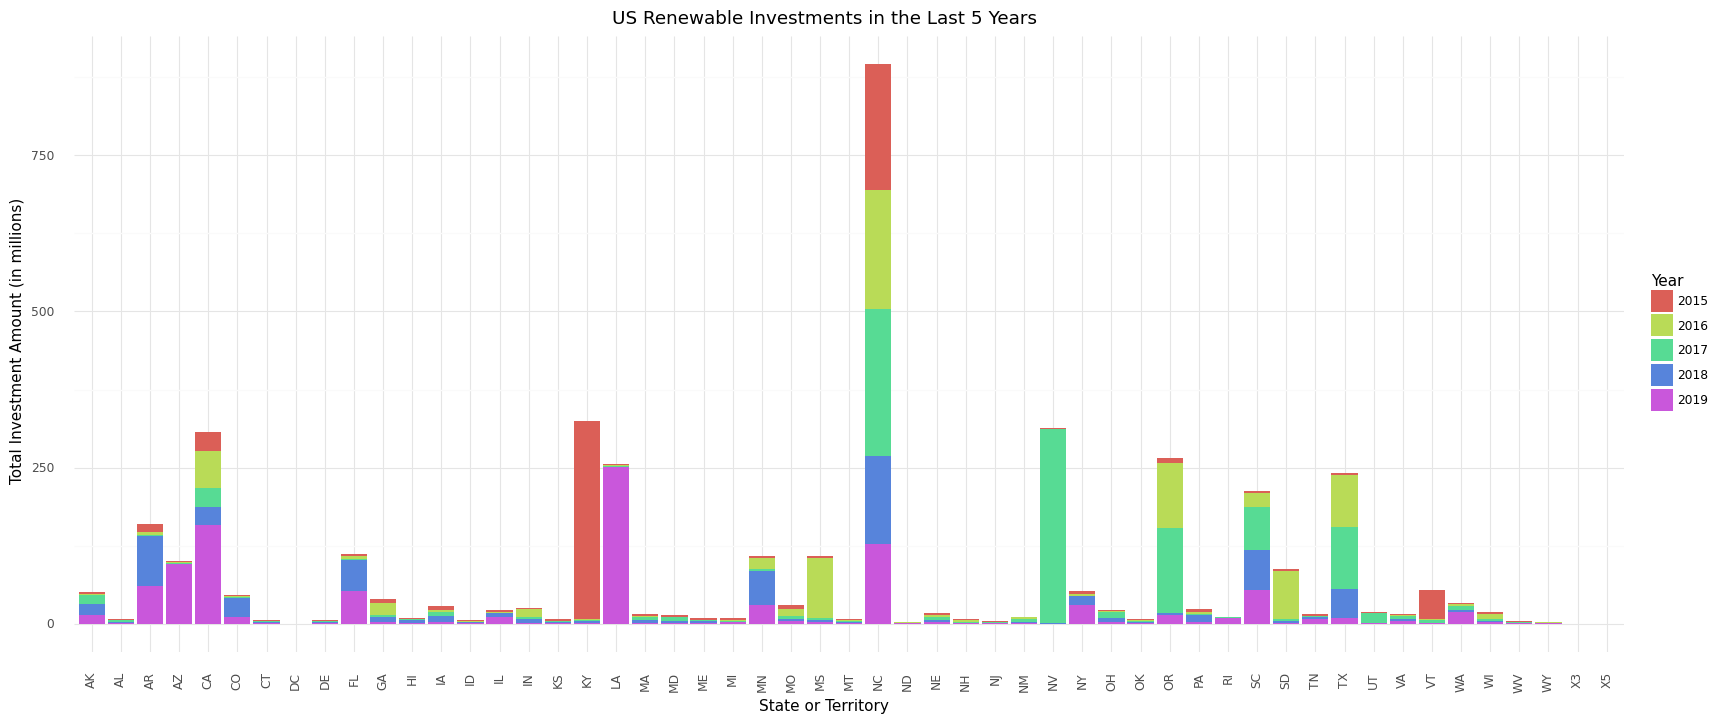

<ggplot: (8734982777317)>

In [255]:
# creates a bar graph for every year to compare states investments against each other
assistance_plot = (ggplot(plot_df, aes(x='StateCode', y='TotalAmountofAssistance', fill='Year'))
                      + geom_col(stat='identity', position='stack') 
                      + ggtitle('US Renewable Investments in the Last 5 Years') 
                      + scale_x_discrete(name = 'State or Territory')
                      + scale_y_continuous(name = 'Total Investment Amount (in millions)', 
                                           labels=[0, 250, 500, 750, 1000])
                      + theme_minimal()
                      + theme(axis_text_x = element_text(angle=90))
                      + theme(figure_size = (20, 8))
                      )
assistance_plot.save("assistance.png", width=20, height=8, dpi=300)
assistance_plot


/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 20 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: invest_num_plot.png


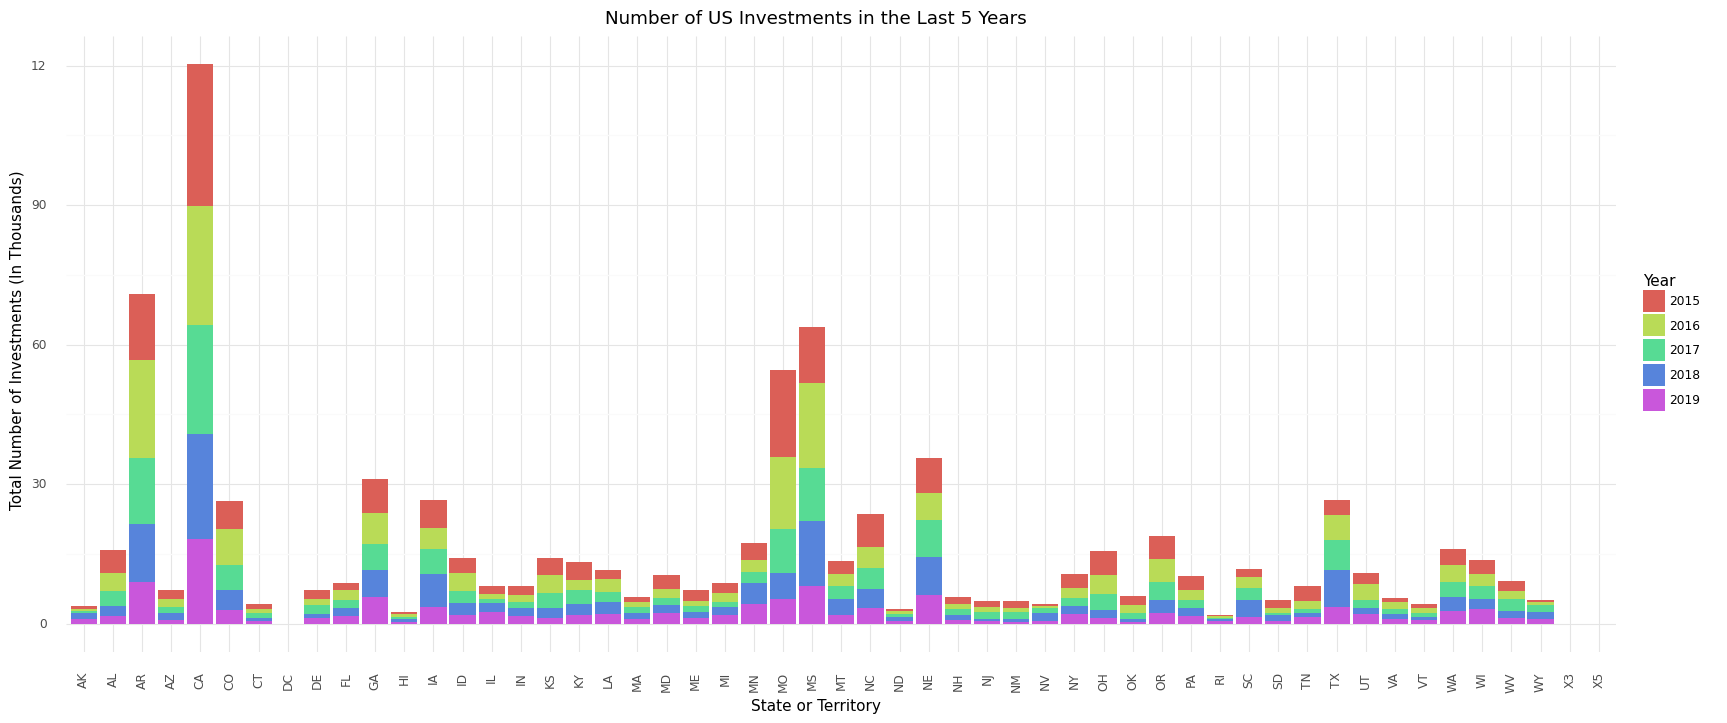

<ggplot: (8734982748889)>

In [256]:
# create a plot to see the number of total investments over the last five years 
invest_num_plot = (ggplot(plot_df, aes(x='StateCode', y='TotalNumberofInvestments', fill='Year'))
                      + geom_col(stat='identity', position='stack') 
                      + ggtitle('Number of US Investments in the Last 5 Years') 
                      + scale_x_discrete(name = 'State or Territory')
                      + scale_y_continuous(name = 'Total Number of Investments (In Thousands)', 
                                           labels = [0, 30, 60, 90, 12])
                      + theme_minimal()
                      + theme(axis_text_x = element_text(angle=90))
                      + theme(figure_size = (20, 8))
                      )
#invest_num_plot.save("invest_num_plot.png", width=20, height=8, dpi=300)
invest_num_plot

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 20 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: reprb_plot.png


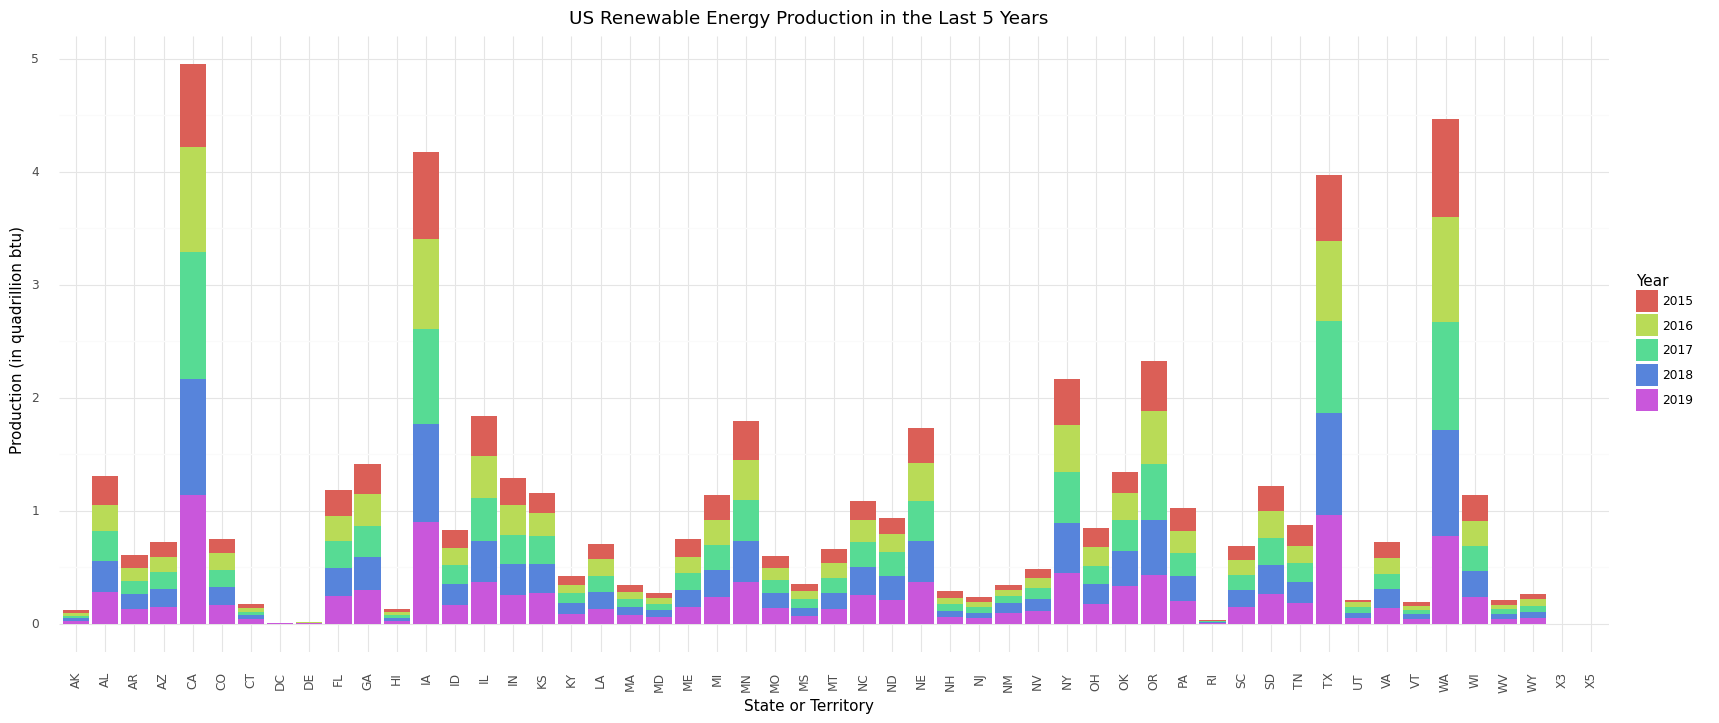

<ggplot: (8734982253743)>

In [257]:
# create a plot to see US renewable energy production over the last five years
reprb_df = plot_df[plot_df['StateCode'] != 'US']
reprb_plot = (ggplot(reprb_df, aes(x='StateCode', y='REPRB', fill='Year'))
                      + geom_col(stat='identity', position='stack') 
                      + ggtitle('US Renewable Energy Production in the Last 5 Years') 
                      + scale_x_discrete(name = 'State or Territory')
                      + scale_y_continuous(name = 'Production (in quadrillion btu)',
                                           labels=[0, 1, 2, 3, 4, 5])
                      + theme_minimal()
                      + theme(axis_text_x = element_text(angle=90))
                      + theme(figure_size = (20, 8))
                      )
#reprb_plot.save("reprb_plot.png", width=20, height=8, dpi=300)
reprb_plot

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 20 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: teprb_plot.png


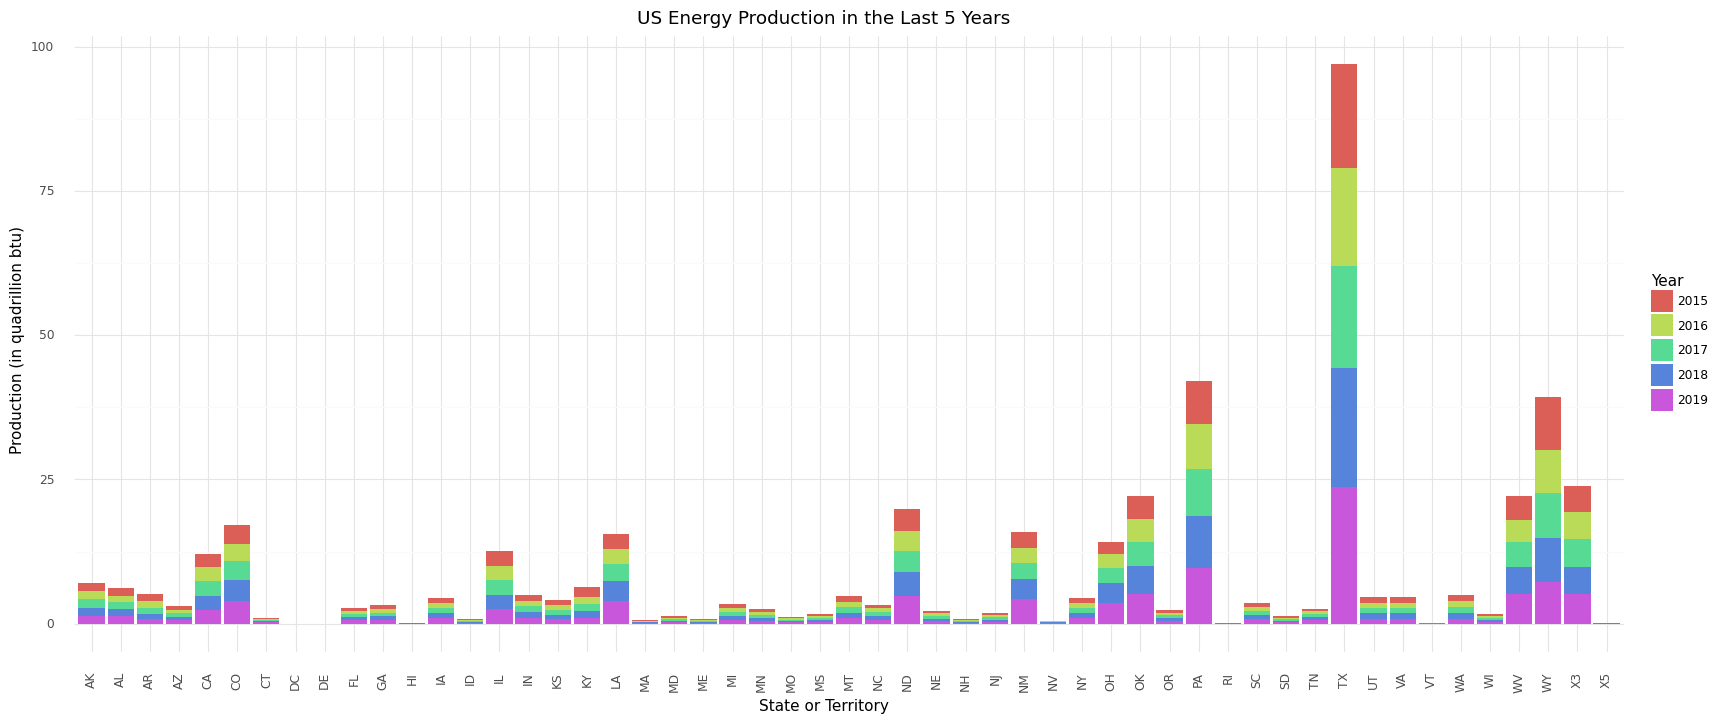

<ggplot: (8734983294100)>

In [258]:
# plot to see total US energy production over the last five years
teprb_plot = (ggplot(reprb_df, aes(x='StateCode', y='TEPRB', fill='Year'))
                      + geom_col(stat='identity', position='stack') 
                      + ggtitle('US Energy Production in the Last 5 Years') 
                      + scale_x_discrete(name = 'State or Territory')
                      + scale_y_continuous(name = 'Production (in quadrillion btu)', 
                                           labels=[0, 25, 50, 75, 100])
                      + theme_minimal()
                      + theme(axis_text_x = element_text(angle=90))
                      + theme(figure_size = (20, 8))
                      )
#teprb_plot.save("teprb_plot.png", width=20, height=8, dpi=300)
teprb_plot

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 20 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: tetcb_plot.png


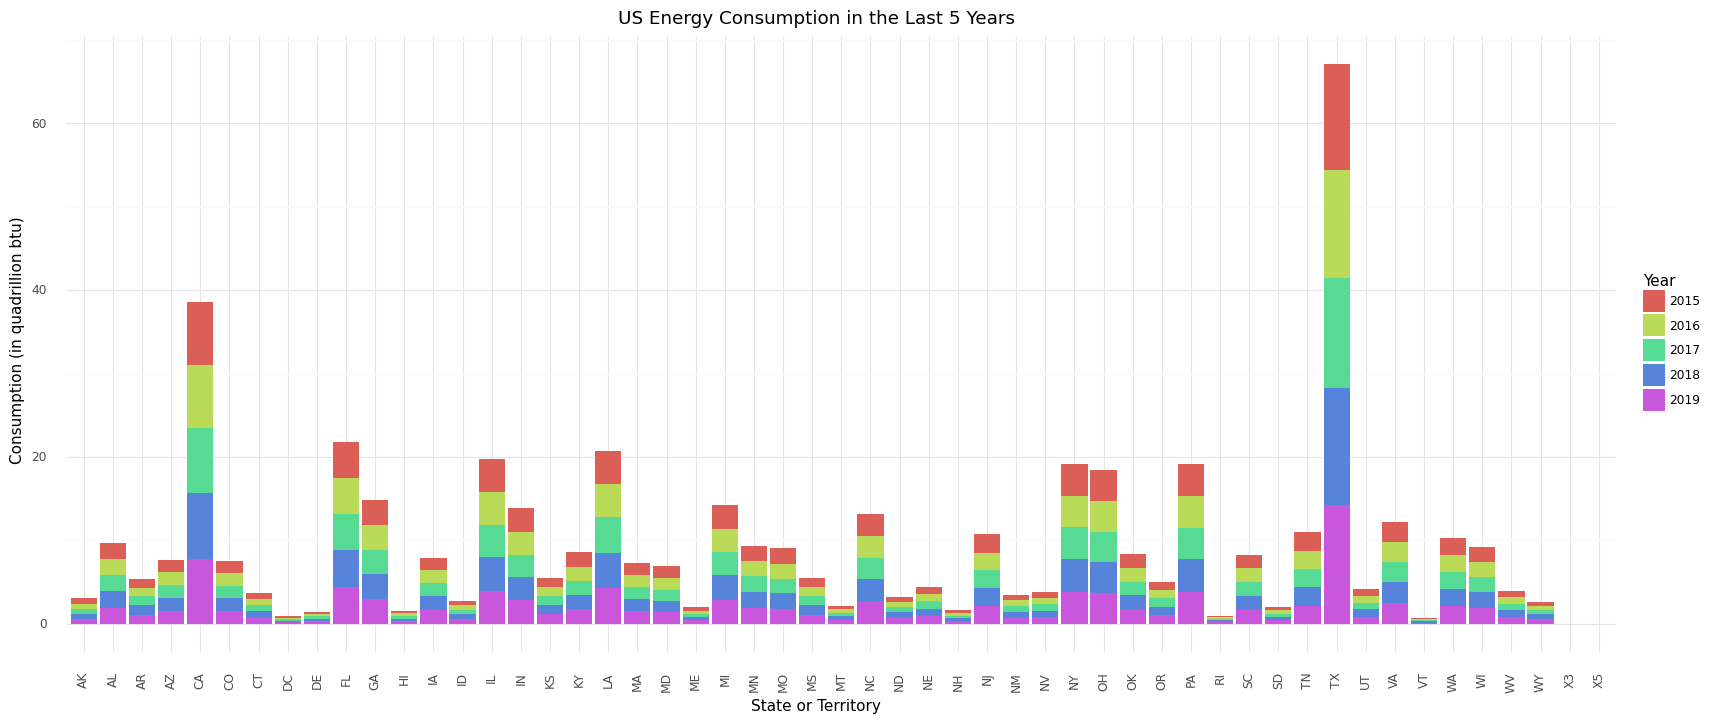

<ggplot: (8734982634304)>

In [259]:
# plot to see total US energy consumption over the last 5 years
tetcb_plot = (ggplot(reprb_df, aes(x='StateCode', y='TETCB', fill='Year'))
                      + geom_col(stat='identity', position='stack') 
                      + ggtitle('US Energy Consumption in the Last 5 Years') 
                      + scale_x_discrete(name = 'State or Territory')
                      + scale_y_continuous(name = 'Consumption (in quadrillion btu)', 
                                           labels=[0, 20, 40, 60, 80])
                      + theme_minimal()
                      + theme(axis_text_x = element_text(angle=90))
                      + theme(figure_size = (20, 8))
                      )
#tetcb_plot.save("tetcb_plot.png", width=20, height=8, dpi=300)
tetcb_plot

# **preprocessing**

In [150]:
# decide categorical and numerical values 
cat_vars = ['StateCode']
num_vars = ['CO2 Emissions (Mmt)', 'TotalNumberofInvestments', 'BDFDB', 'BDPRP', 'BFFDB', 'BFPRP', 
            'CLPRB', 'CLPRK', 'CLPRP', 'COPRK', 'EMFDB', 'ENPRP', 'GETCB', 
            'HYTCB', 'NCPRB', 'NGMPB', 'NGMPK', 'NGMPP', 'NUETB', 'PAPRB', 
            'PAPRP', 'REPRB', 'SOTCB', 'TEPRB', 'TETCB', 'WDEXB', 'WDPRB', 
            'WDTCB', 'WSTCB', 'WWPRB', 'WYTCB']

In [151]:
feat_df

MSN,State,Year,StateCode,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance,BDFDB,BDPRP,BFFDB,BFPRP,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
0,Alabama,2015,AL,119.200889,164.0,1864412.0,1933.0,356.0,1933.0,356.0,...,258955.0,101.0,1267004.0,1917138.0,0.0,163313.0,163313.0,1565.0,164877.0,0.0
1,Alabama,2016,AL,113.983783,129.0,1206793.0,1906.0,351.0,1906.0,351.0,...,230734.0,431.0,1118407.0,1922727.0,0.0,162166.0,162166.0,1606.0,163772.0,0.0
2,Alabama,2017,AL,108.594378,104.0,2414699.0,1585.0,292.0,1585.0,292.0,...,258549.0,1812.0,1230179.0,1904206.0,1137.0,168195.0,167058.0,1712.0,169907.0,0.0
3,Alabama,2018,AL,112.355471,75.0,1844186.0,1652.0,304.0,1652.0,304.0,...,279560.0,3425.0,1245875.0,1956413.0,4462.0,171215.0,166753.0,1680.0,172895.0,0.0
4,Alabama,2019,AL,106.250752,54.0,840218.0,1494.0,275.0,1494.0,275.0,...,278142.0,3628.0,1250624.0,1926332.0,5308.0,169739.0,164431.0,1577.0,171316.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,Wyoming,2015,WY,64.092863,18.0,249960.0,0.0,0.0,1192.0,209.0,...,49887.0,27.0,9080777.0,507121.0,0.0,4904.0,4904.0,2.0,4905.0,35009.0
261,Wyoming,2016,WY,61.259993,23.0,1359346.0,0.0,0.0,0.0,0.0,...,54565.0,33.0,7518440.0,504984.0,0.0,4357.0,4357.0,2.0,4358.0,40522.0
262,Wyoming,2017,WY,62.796487,47.0,413987.0,0.0,0.0,0.0,0.0,...,55916.0,45.0,7794586.0,534840.0,0.0,5049.0,5049.0,0.0,5049.0,39806.0
263,Wyoming,2018,WY,63.846081,53.0,573639.0,0.0,0.0,0.0,0.0,...,51483.0,67.0,7711992.0,557604.0,0.0,4934.0,4934.0,0.0,4934.0,36936.0


In [152]:
def pre_split_clean(df):
  clean = df.copy(deep=True)
  clean.TotalAmountofAssistance.fillna(0, inplace=True)
  clean.drop(cat_vars, axis=1, inplace=True)
  cat_df = pd.get_dummies(df[cat_vars])
  clean = cat_df.join(clean)
  return clean

In [153]:
# split the data into test and training sets
split_df = pre_split_clean(feat_df)
print(split_df)
X = split_df.drop(['TotalAmountofAssistance'], axis=1)
y = split_df[['TotalAmountofAssistance']]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=6)

     StateCode_AK  StateCode_AL  StateCode_AR  StateCode_AZ  StateCode_CA  \
0               0             1             0             0             0   
1               0             1             0             0             0   
2               0             1             0             0             0   
3               0             1             0             0             0   
4               0             1             0             0             0   
..            ...           ...           ...           ...           ...   
260             0             0             0             0             0   
261             0             0             0             0             0   
262             0             0             0             0             0   
263             0             0             0             0             0   
264             0             0             0             0             0   

     StateCode_CO  StateCode_CT  StateCode_DC  StateCode_DE  StateCode_FL  

In [154]:
def clean_data(df):
  # fill missing investment data with 0's, assume none were made
  # fill missing MSN data with 0's assume no output
  num_df = df[num_vars]
  num_df.fillna(0, inplace=True)
  clean = df.drop(num_vars, axis=1, inplace=False)
  clean.reset_index(inplace=True)
  clean.drop(['index'], axis=1, inplace=True)

  # scale numerical data and impute CO2 emissions
  scaler = StandardScaler()
  num_df = scaler.fit_transform(num_df)
  num_df = pd.DataFrame(num_df, columns=num_vars)

  # join together
  clean = clean.join(num_df)

  # extract states 
  states = clean[['State']]
  clean.drop(['State'], axis=1, inplace=True)

  return clean, states

In [155]:
X_train_clean, train_states = clean_data(X_train)
X_valid_clean, valid_states = clean_data(X_valid)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [156]:
X_train_clean

,StateCode_AK,StateCode_AL,StateCode_AR,StateCode_AZ,StateCode_CA,StateCode_CO,StateCode_CT,StateCode_DC,StateCode_DE,StateCode_FL,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
0,0,0,0,0,0,0,0,0,0,0,...,-0.726129,0.218824,-0.392014,0.089125,-0.323774,-0.901894,-0.909748,0.557770,-0.669811,-0.453119
1,0,0,0,0,0,0,0,0,0,0,...,0.447114,-0.286970,-0.379688,-0.453707,-0.323774,-0.906150,-0.914163,-0.585024,-0.942030,-0.104094
2,0,0,0,0,0,0,0,0,0,0,...,-0.661405,-0.282970,-0.465763,-0.700330,-0.323774,-0.106575,-0.084881,-0.367753,-0.180998,-0.415674
3,0,0,0,0,0,0,0,0,0,0,...,0.006966,-0.278752,-0.414352,-0.033240,-0.323774,1.095382,1.161734,0.029083,0.979467,-0.306901
4,0,0,0,0,0,0,0,0,0,1,...,0.005009,0.322121,-0.348980,1.101689,2.431469,1.339204,1.196284,5.003262,2.364368,-0.455192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0,0,0,0,0,0,0,0,0,0,...,0.547613,-0.250373,0.305847,0.904629,-0.323774,-0.793018,-0.796827,0.180468,-0.661744,0.547569
181,0,1,0,0,0,0,0,0,0,0,...,0.035147,-0.280217,-0.172666,0.015004,-0.323774,2.467991,2.585341,-0.589588,2.052941,-0.455192
182,0,0,0,0,0,0,0,0,0,0,...,-0.329968,-0.280475,-0.471450,-0.666758,-0.323774,1.040022,1.104318,-0.432358,0.821920,-0.301094
183,0,0,0,0,0,0,0,0,0,0,...,2.419000,0.209417,4.907609,5.025920,-0.323774,0.202009,0.235169,1.309493,0.486969,5.730668


In [157]:
X_valid_clean

,StateCode_AK,StateCode_AL,StateCode_AR,StateCode_AZ,StateCode_CA,StateCode_CO,StateCode_CT,StateCode_DC,StateCode_DE,StateCode_FL,...,REPRB,SOTCB,TEPRB,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB
0,0,0,1,0,0,0,0,0,0,0,...,-0.196988,-0.311024,-0.380093,-0.369331,1.686330,0.864135,0.767858,-0.421320,0.645003,-0.484319
1,0,0,0,0,0,0,0,0,0,0,...,0.055987,-0.376191,-0.375080,-0.366627,-0.390365,-0.714751,-0.729648,-0.520794,-0.747378,0.874667
2,0,0,0,0,0,0,0,0,0,0,...,-0.644540,-0.377452,2.263039,-0.661330,-0.390365,-0.703154,-0.717213,-0.714874,-0.785083,0.043471
3,0,0,0,0,0,0,0,0,0,0,...,-0.007186,-0.328359,-0.502406,0.176156,-0.390365,0.282633,0.339787,-0.308766,0.168916,-0.479028
4,0,0,0,0,0,0,0,0,0,0,...,-0.828660,-0.349361,-0.309677,-0.524348,-0.390365,-0.729650,-0.745623,-0.610967,-0.782473,-0.406979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,0,0,0,0,0,0,0,0,0,...,-0.939936,-0.365284,-0.696441,-0.843124,-0.390365,-0.772509,-0.791578,-0.561557,-0.807430,-0.481070
76,0,0,0,0,0,0,0,0,0,0,...,-0.142166,-0.363872,-0.319154,-0.712553,-0.390365,-0.429015,-0.423270,-0.684574,-0.540120,-0.224389
77,0,0,0,0,0,1,0,0,0,0,...,-0.236940,-0.190424,0.515260,-0.159014,-0.390365,-0.522492,-0.523500,-0.632548,-0.608324,0.439333
78,0,0,0,0,0,0,0,0,0,0,...,-0.823100,-0.127631,-0.688745,-0.783949,-0.390365,-0.806557,-0.828086,-0.193016,-0.746270,-0.408610


# **Testing Models**

In [158]:
#copies of data sets
X_train_linreg = X_train_clean.copy()
X_valid_linreg = X_valid_clean.copy()

scaler = MinMaxScaler()
# linear regression
lr = LinearRegression()
lr.fit(X_train_linreg, y_train)
y_valid_pred = scaler.fit_transform(pd.DataFrame(lr.predict(X_valid_linreg)))
mean_squared_error(scaler.fit_transform(y_valid), y_valid_pred, squared=False)

0.25308324404469146

In [159]:
X_train_lasso = X_train_clean.copy()
X_test_lasso = X_valid_clean.copy()
lasso = Lasso(alpha=20)
lasso.fit(X_train_lasso, y_train)
minmax_scaler = MinMaxScaler(feature_range=(0,1))
pred_lasso = minmax_scaler.fit_transform(pd.DataFrame(lasso.predict(X_test_lasso)))
mean_squared_error(minmax_scaler.fit_transform(pd.DataFrame(y_valid)), pred_lasso, squared=False)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.273e+16, tolerance: 4.096e+13


0.5514463876499703

In [160]:
alphas = np.concatenate([np.arange(0,100,5), np.arange(100,1000,100), np.arange(1000,30000,1000)])

hp_rmse = []
for hp in alphas: 
  X_train_lasso = X_train_clean.copy()
  X_valid_lasso = X_valid_clean.copy()
  lasso = Lasso(alpha=hp)
  lasso.fit(X_train_lasso, y_train)
  minmax_scaler = MinMaxScaler(feature_range=(0,1))
  pred_train_lasso = minmax_scaler.fit_transform(pd.DataFrame(lasso.predict(X_train_lasso)))
  pred_valid_lasso = minmax_scaler.fit_transform(pd.DataFrame(lasso.predict(X_valid_lasso)))
  rmse_train = mean_squared_error(minmax_scaler.fit_transform(pd.DataFrame(y_train)), pred_train_lasso, squared=False)
  rmse_validation = mean_squared_error(minmax_scaler.fit_transform(pd.DataFrame(y_valid)), pred_valid_lasso, squared=False)
  hp_rmse.append([hp, rmse_train, rmse_validation])

hp_df = pd.DataFrame(hp_rmse, columns =['alpha_value', 'training_rmse', 'validation_rmse'], dtype = float) 
hp_df

<ipython-input-160-f2cf09423a18>:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.273e+16, tolerance: 4.096e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increa

,alpha_value,training_rmse,validation_rmse
0,0.0,0.183689,0.551667
1,5.0,0.183681,0.551612
2,10.0,0.183672,0.551557
3,15.0,0.183664,0.551502
4,20.0,0.183656,0.551446
5,25.0,0.183647,0.551391
6,30.0,0.183639,0.551336
7,35.0,0.183630,0.551280
8,40.0,0.183622,0.551225
9,45.0,0.183613,0.551169


/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: alphas_train_plot.png


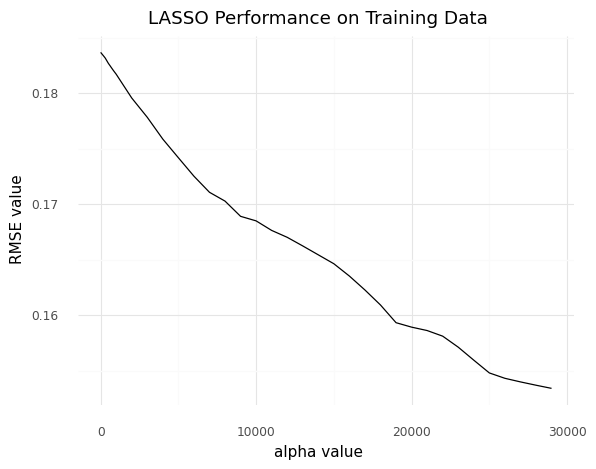

<ggplot: (8734980526526)>

In [261]:
# create plot of RMSE on training data 
alphas_train_plot = (ggplot(hp_df, aes(x='alpha_value', y='training_rmse'))
                      + geom_line() 
                      + ggtitle('LASSO Performance on Training Data') 
                      + scale_x_continuous(name = 'alpha value')
                      + scale_y_continuous(name = 'RMSE value')
                      + theme(axis_text_x = element_text(angle=90))
                      + theme_minimal()
                      )
#alphas_train_plot.save("alphas_train_plot.png", width=12, height=8, dpi=300)
alphas_train_plot

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: alphas_valid_plot.png


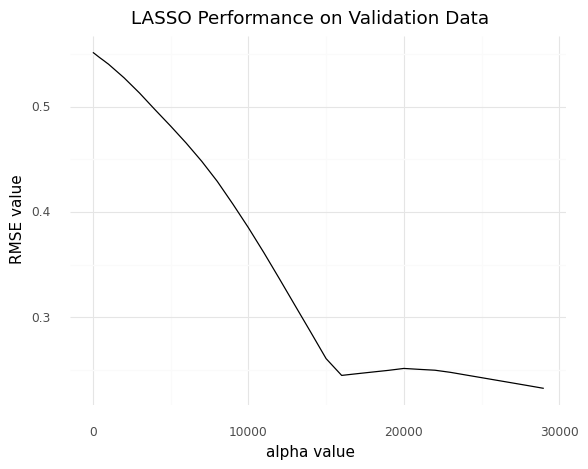

<ggplot: (8734986560765)>

In [266]:
# create plot of RMSE on test data 
alphas_valid_plot = (ggplot(hp_df, aes(x='alpha_value', y='validation_rmse'))
                      + geom_line() 
                      + ggtitle('LASSO Performance on Validation Data') 
                      + scale_x_continuous(name = 'alpha value')
                      + scale_y_continuous(name = 'RMSE value')
                      + theme(axis_text_x = element_text(angle=90))
                      + theme_minimal()
                      )
#alphas_valid_plot.save("alphas_valid_plot.png", width=12, height=8, dpi=300)
alphas_valid_plot

In [202]:
y_train_scaled = minmax_scaler.fit_transform(pd.DataFrame(y_train))
y_valid_scaled = minmax_scaler.fit_transform(pd.DataFrame(y_valid))
X_train_dtr = X_train_clean.copy()
X_valid_dtr = X_valid_clean.copy()

depth_results = []
for depth in list(range(1, 51)): 
  results = [depth]
  clf = DecisionTreeRegressor(max_depth = depth)
  dt_clf = clf.fit(X_train_dtr, y_train)

  pred_valid_dtr = minmax_scaler.fit_transform(pd.DataFrame(dt_clf.predict(X_valid_dtr)))
  rmse_valid_dtr = mean_squared_error(y_valid_scaled, pred_valid_dtr, squared=False)

  pred_train_dtr = minmax_scaler.fit_transform(pd.DataFrame(dt_clf.predict(X_train_dtr)))
  rmse_train_dtr = mean_squared_error(y_train_scaled, pred_train_dtr, squared=False)

  results.append(abs(rmse_train_dtr))
  results.append(abs(rmse_valid_dtr))
  depth_results.append(results)

train_valid_dtr = pd.DataFrame(depth_results, columns=['max_depth', 'training', 'validation'])
train_valid_dtr

,max_depth,training,validation
0,1,1.423539e-01,0.148263
1,2,1.294700e-01,0.155992
2,3,9.675048e-02,0.178532
3,4,5.752352e-02,0.166974
4,5,3.810502e-02,0.235557
5,6,2.795445e-02,0.225021
6,7,1.382717e-02,0.196877
7,8,1.173188e-02,0.220045
8,9,9.553765e-03,0.171413
9,10,6.782677e-03,0.183721


/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: dtr_plot.png


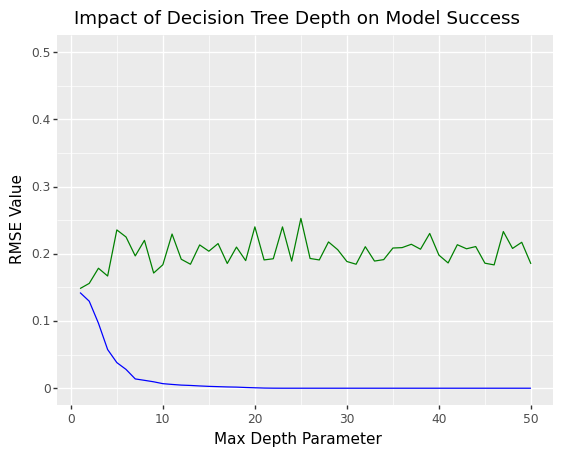

<ggplot: (8734982774215)>

In [276]:
dtr_plot = (ggplot(train_valid_dtr, aes(show_legend=True))
              + geom_line(aes(x='max_depth', y='training'), color='blue')
              + geom_line(aes(x='max_depth', y='validation'), color='green')
              #+ ylab('RMSE value')
              #+ scale_x_discrete(name='Max Depth Parameter')
              + ggtitle('Impact of Decision Tree Depth on Model Success')
              + ylim(0, 0.5)
              + ylab('RMSE Value')
              + xlab('Max Depth Parameter')
              )
#dtr_plot.save("dtr_plot.png", width=12, height=8, dpi=300)
dtr_plot

In [226]:
X_train_final = X_train_clean.copy()
X_valid_final = X_valid_clean.copy()

clf = DecisionTreeRegressor(max_depth = 7)
clf = clf.fit(X_train_final, y_train)

pred_valid_dtr = minmax_scaler.fit_transform(pd.DataFrame(clf.predict(X_valid_dtr)))
rmse_valid_dtr = mean_squared_error(y_valid_scaled, pred_valid_dtr, squared=False)

pred_train_dtr = minmax_scaler.fit_transform(pd.DataFrame(clf.predict(X_train_dtr)))
rmse_train_dtr = mean_squared_error(y_train_scaled, pred_train_dtr, squared=False)

print("On the training data, the RMSE (standardized) is : ", rmse_train_dtr)
#print(train_states.join(pd.DataFrame(clf.predict(X_train_dtr))))

print("On the validation data, the RMSE (standardized) is : ", rmse_valid_dtr)
#print(valid_states.join(pd.DataFrame(clf.predict(X_valid_dtr))))


On the training data, the RMSE (standardized) is :  0.013827171608146237
On the validation data, the RMSE (standardized) is :  0.18958699512251118


# **Make Predictions**

In [237]:
# bring in 2020 data
url_2020 = 'https://raw.githubusercontent.com/isa-estes/rice-datathon23/main/Investment_Data_2020_withResponseVariable.xlsx%20-%202020_data.csv'
df_2020 = pd.read_csv(url_2020)

data_2020 = pre_clean(df_2020)
data_split_2020 = pre_split_clean(data_2020)
aid_2020 = minmax_scaler.fit_transform(data_split_2020[['TotalAmountofAssistance']])
feat_2020, states_2020 = clean_data(data_split_2020.drop(['TotalAmountofAssistance'], axis=1))
feat_2020['StateCode_X3'] = 0
feat_2020['StateCode_X5'] = 0

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [277]:
training_data = pre_split_clean(feat_df)
train_aid = training_data[['TotalAmountofAssistance']]
train_aid_std = minmax_scaler.fit_transform(training_data[['TotalAmountofAssistance']])
train_feat, training_states = clean_data(training_data.drop(['TotalAmountofAssistance'], axis=1))

clf_2020 = DecisionTreeRegressor(max_depth = 7)
dt_clf_2020 = clf_2020.fit(train_feat, train_aid)

pred_train_dtr = minmax_scaler.fit_transform(pd.DataFrame(dt_clf_2020.predict(train_feat)))
rmse_train_dtr = mean_squared_error(train_aid_std, pred_train_dtr, squared=False)

pred_2020_dtr = minmax_scaler.fit_transform(pd.DataFrame(dt_clf_2020.predict(feat_2020)))
rmse_pred_dtr = mean_squared_error(aid_2020, pred_2020_dtr, squared=False)

print("On 2015-19 data, the RMSE (standardized) is : ", rmse_train_dtr)
#print(training_states.join(pd.DataFrame(dt_clf_2020.predict(train_feat))))

print("On 2020 data, the RMSE (standardized) is : ", rmse_pred_dtr)
predictions = states_2020.join(pd.DataFrame(dt_clf_2020.predict(feat_2020), 
                                            columns=['TotalAmountofAssistance']))

On 2015-19 data, the RMSE (standardized) is :  0.036098914365715155
On 2020 data, the RMSE (standardized) is :  0.29551225811726917


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.



In [280]:
int_pred = minmax_scaler.fit_transform(pd.DataFrame(dt_clf_2020.predict(feat_2020)))
pred_std = states_2020.join(pd.DataFrame(int_pred, columns=['AidAmount']))
#pred_std

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.



In [281]:
predictions

,State,TotalAmountofAssistance
0,Alabama,8.360708e+07
1,Alaska,4.062819e+06
2,Arizona,4.062819e+06
3,Arkansas,4.062819e+06
4,California,2.506952e+08
5,Colorado,4.062819e+06
6,Connecticut,4.062819e+06
7,Delaware,4.062819e+06
8,District of Columbia,4.062819e+06
9,Florida,4.062819e+06


In [284]:
# rescale the predictions
df_aid = df_2020[['State']]
scaled_pred = df_aid.merge(predictions, how='left', on='State')

In [285]:
scaled_pred[['TotalAmountofAssistance']].to_excel('submission_file.xlsx')

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 20 x 8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: aid_pred_plot.png


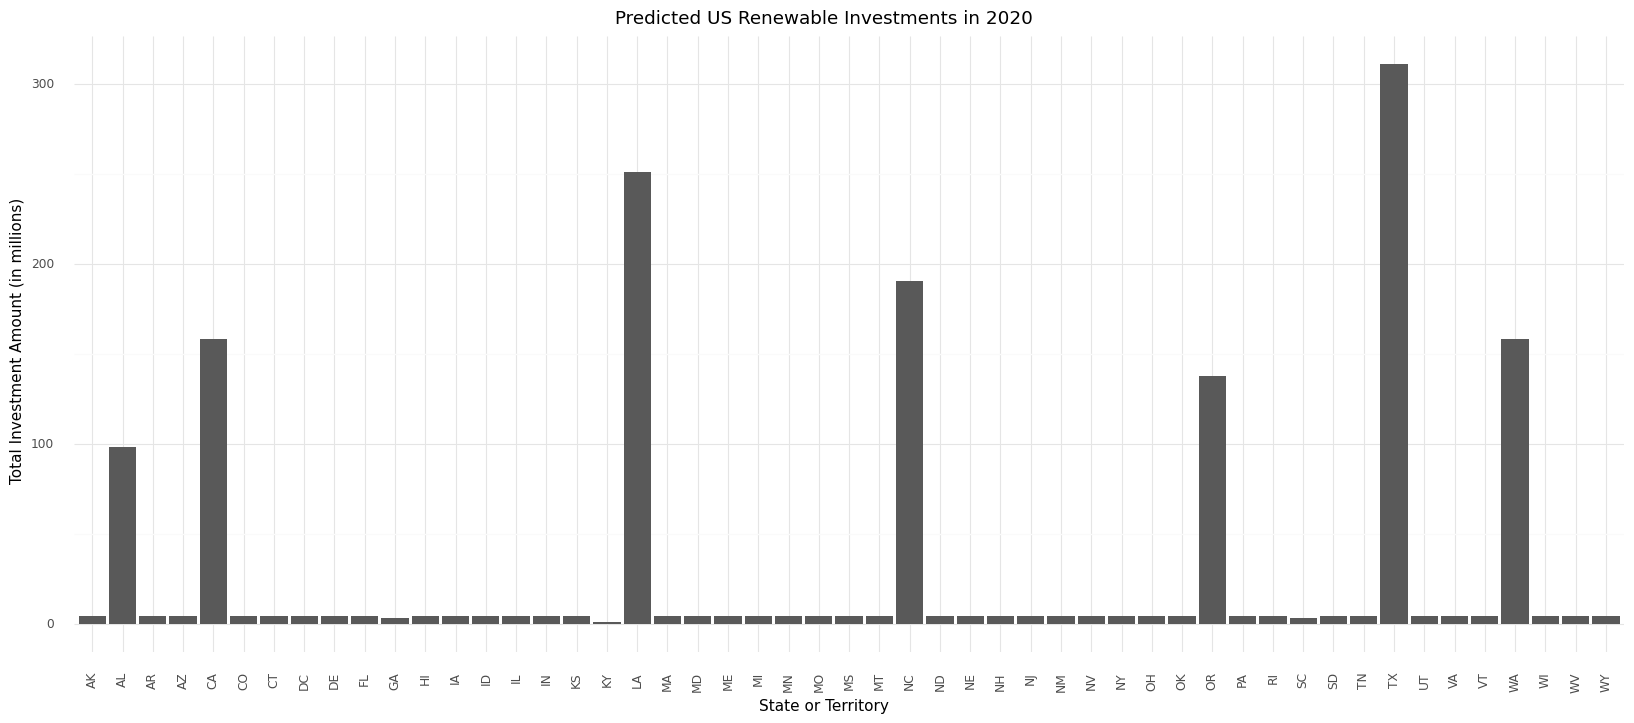

<ggplot: (8734982242347)>

In [254]:
# creates a bar graph for every year to compare states investments against each other
pred_df = data_2020[['StateCode']].join(predictions)
aid_pred_plot = (ggplot(pred_df.drop_duplicates(), aes(x='StateCode', y='AidAmount'))
                      + geom_col() 
                      + ggtitle('Predicted US Renewable Investments in 2020') 
                      + scale_x_discrete(name = 'State or Territory')
                      + scale_y_continuous(name = 'Total Investment Amount (in millions)', 
                                           labels = [0, 100, 200, 300])
                      + theme_minimal()
                      + theme(axis_text_x = element_text(angle=90))
                      + theme(figure_size = (20, 8))
                      )
#aid_pred_plot.save("aid_pred_plot.png", width=20, height=8, dpi=300)
aid_pred_plot